In [59]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [60]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.001
training_iters = 25000000
batch_size = 128
display_step = 100
display_testing_step = 400

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 128 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [61]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [47]:
tf.reset_default_graph()

tf.set_random_seed(0.5)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [48]:
num_layers = 2

def RNN(x, W, b):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)
 
    stacked_rnn = []
    for i in range(num_layers):
        stacked_rnn.append(tf.nn.rnn_cell.LSTMCell(n_hidden, state_is_tuple=True, use_peepholes=True))
    

    lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']



In [49]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [50]:
# Initializing the variables
init = tf.global_variables_initializer()


In [51]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
        batch_val_y = y_test[offset_val:(offset_val + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                  "{:.6f}".format(loss_test)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 12800, Minibatch Loss= 0.775383, Minibatch Val Loss= 1.043406
Iter 25600, Minibatch Loss= 0.023950, Minibatch Val Loss= 2.040279
Iter 38400, Minibatch Loss= 0.005367, Minibatch Val Loss= 0.666161
Iter 51200, Minibatch Loss= 0.159055, Minibatch Val Loss= 0.104002
Iter 64000, Minibatch Loss= 0.017239, Minibatch Val Loss= 0.072986
Iter 76800, Minibatch Loss= 0.343751, Minibatch Val Loss= 0.374818
Iter 89600, Minibatch Loss= 0.021952, Minibatch Val Loss= 1.705682
Iter 102400, Minibatch Loss= 0.013195, Minibatch Val Loss= 1.857378
Iter 115200, Minibatch Loss= 0.004999, Minibatch Val Loss= 2.043598
Iter 128000, Minibatch Loss= 0.001828, Minibatch Val Loss= 4.879605
Iter 140800, Minibatch Loss= 2.688622, Minibatch Val Loss= 5.605820
Iter 153600, Minibatch Loss= 0.015907, Minibatch Val Loss= 0.128001
Iter 166400, Minibatch Loss= 0.004012, Minibatch Val Loss= 2.597216
Iter 179200, Minibatch Loss= 0.002253, Minibatch Val Loss= 0.053584
Iter 192000, Minibatch Loss= 0.001516, Minibatch Val Lo

Iter 1548800, Minibatch Loss= 0.000290, Minibatch Val Loss= 0.000549
Iter 1561600, Minibatch Loss= 0.042782, Minibatch Val Loss= 0.000583
Iter 1574400, Minibatch Loss= 0.060032, Minibatch Val Loss= 0.000266
Iter 1587200, Minibatch Loss= 0.004652, Minibatch Val Loss= 0.000300
Iter 1600000, Minibatch Loss= 0.000216, Minibatch Val Loss= 0.000375
Iter 1612800, Minibatch Loss= 0.000136, Minibatch Val Loss= 0.000141
Iter 1625600, Minibatch Loss= 0.066313, Minibatch Val Loss= 0.000155
Iter 1638400, Minibatch Loss= 0.000144, Minibatch Val Loss= 0.004022
Iter 1651200, Minibatch Loss= 0.000124, Minibatch Val Loss= 1.311281
Iter 1664000, Minibatch Loss= 0.000113, Minibatch Val Loss= 0.361117
Iter 1676800, Minibatch Loss= 0.000096, Minibatch Val Loss= 0.347542
Iter 1689600, Minibatch Loss= 0.000089, Minibatch Val Loss= 1.676370
Iter 1702400, Minibatch Loss= 0.000083, Minibatch Val Loss= 0.046504
Iter 1715200, Minibatch Loss= 0.000077, Minibatch Val Loss= 0.335783
Iter 1728000, Minibatch Loss= 0.00

Iter 3072000, Minibatch Loss= 0.000704, Minibatch Val Loss= 0.000164
Iter 3084800, Minibatch Loss= 0.000060, Minibatch Val Loss= 1.025068
Iter 3097600, Minibatch Loss= 0.000024, Minibatch Val Loss= 0.000080
Iter 3110400, Minibatch Loss= 0.238575, Minibatch Val Loss= 0.000021
Iter 3123200, Minibatch Loss= 0.000019, Minibatch Val Loss= 0.000019
Iter 3136000, Minibatch Loss= 0.000018, Minibatch Val Loss= 0.000018
Iter 3148800, Minibatch Loss= 0.000016, Minibatch Val Loss= 0.963988
Iter 3161600, Minibatch Loss= 0.000015, Minibatch Val Loss= 0.000019
Iter 3174400, Minibatch Loss= 0.000014, Minibatch Val Loss= 0.000014
Iter 3187200, Minibatch Loss= 0.000014, Minibatch Val Loss= 0.294246
Iter 3200000, Minibatch Loss= 0.000014, Minibatch Val Loss= 0.990780
Iter 3212800, Minibatch Loss= 0.000013, Minibatch Val Loss= 0.024027
Iter 3225600, Minibatch Loss= 0.000013, Minibatch Val Loss= 0.077257
Iter 3238400, Minibatch Loss= 0.000012, Minibatch Val Loss= 4.254117
Iter 3251200, Minibatch Loss= 0.00

Iter 4595200, Minibatch Loss= 0.001851, Minibatch Val Loss= 0.000012
Iter 4608000, Minibatch Loss= 0.000010, Minibatch Val Loss= 0.000010
Iter 4620800, Minibatch Loss= 0.000010, Minibatch Val Loss= 0.000010
Iter 4633600, Minibatch Loss= 0.000009, Minibatch Val Loss= 0.000009
Iter 4646400, Minibatch Loss= 0.000009, Minibatch Val Loss= 0.000023
Iter 4659200, Minibatch Loss= 0.000008, Minibatch Val Loss= 0.000022
Iter 4672000, Minibatch Loss= 0.000008, Minibatch Val Loss= 1.050614
Iter 4684800, Minibatch Loss= 0.000008, Minibatch Val Loss= 0.000008
Iter 4697600, Minibatch Loss= 0.000007, Minibatch Val Loss= 0.000007
Iter 4710400, Minibatch Loss= 0.000007, Minibatch Val Loss= 0.000007
Iter 4723200, Minibatch Loss= 0.000007, Minibatch Val Loss= 0.000007
Iter 4736000, Minibatch Loss= 0.000007, Minibatch Val Loss= 0.000007
Iter 4748800, Minibatch Loss= 0.000006, Minibatch Val Loss= 0.000036
Iter 4761600, Minibatch Loss= 0.000006, Minibatch Val Loss= 3.224558
Iter 4774400, Minibatch Loss= 0.00

Iter 6118400, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.127496
Iter 6131200, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000004
Iter 6144000, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000059
Iter 6156800, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000003
Iter 6169600, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000003
Iter 6182400, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000003
Iter 6195200, Minibatch Loss= 0.000003, Minibatch Val Loss= 1.592549
Iter 6208000, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000003
Iter 6220800, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000003
Iter 6233600, Minibatch Loss= 0.000002, Minibatch Val Loss= 0.000002
Iter 6246400, Minibatch Loss= 0.000002, Minibatch Val Loss= 0.000002
Iter 6259200, Minibatch Loss= 0.000002, Minibatch Val Loss= 3.447936
Iter 6272000, Minibatch Loss= 0.000833, Minibatch Val Loss= 0.000003
Iter 6284800, Minibatch Loss= 0.000002, Minibatch Val Loss= 0.000002
Iter 6297600, Minibatch Loss= 0.00

Iter 7641600, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.001083
Iter 7654400, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000387
Iter 7667200, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000196
Iter 7680000, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000001
Iter 7692800, Minibatch Loss= 0.000001, Minibatch Val Loss= 2.560065
Iter 7705600, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000001
Iter 7718400, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000001
Iter 7731200, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000001
Iter 7744000, Minibatch Loss= 0.000001, Minibatch Val Loss= 3.258079
Iter 7756800, Minibatch Loss= 0.000400, Minibatch Val Loss= 0.000000
Iter 7769600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7782400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7795200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 7808000, Minibatch Loss= 0.000002, Minibatch Val Loss= 1.261689
Iter 7820800, Minibatch Loss= 0.00

Iter 9164800, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.075927
Iter 9177600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000088
Iter 9190400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.001557
Iter 9203200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000191
Iter 9216000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000304
Iter 9228800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.025775
Iter 9241600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9254400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9267200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9280000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9292800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9305600, Minibatch Loss= 0.000000, Minibatch Val Loss= 2.725638
Iter 9318400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9331200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 9344000, Minibatch Loss= 0.01

Iter 10675200, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000033
Iter 10688000, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000225
Iter 10700800, Minibatch Loss= 0.000001, Minibatch Val Loss= 6.490932
Iter 10713600, Minibatch Loss= 0.000001, Minibatch Val Loss= 4.191786
Iter 10726400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.089762
Iter 10739200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000219
Iter 10752000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000017
Iter 10764800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000026
Iter 10777600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000006
Iter 10790400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 10803200, Minibatch Loss= 0.000000, Minibatch Val Loss= 4.149045
Iter 10816000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 10828800, Minibatch Loss= 0.000342, Minibatch Val Loss= 0.000000
Iter 10841600, Minibatch Loss= 0.000009, Minibatch Val Loss= 0.000038
Iter 10854400, Minib

Iter 12185600, Minibatch Loss= 0.000002, Minibatch Val Loss= 0.000002
Iter 12198400, Minibatch Loss= 0.014582, Minibatch Val Loss= 0.000002
Iter 12211200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000003
Iter 12224000, Minibatch Loss= 0.034681, Minibatch Val Loss= 2.236868
Iter 12236800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.001930
Iter 12249600, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.856537
Iter 12262400, Minibatch Loss= 0.000000, Minibatch Val Loss= 2.578353
Iter 12275200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.003028
Iter 12288000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000480
Iter 12300800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000213
Iter 12313600, Minibatch Loss= 0.000135, Minibatch Val Loss= 0.000025
Iter 12326400, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000007
Iter 12339200, Minibatch Loss= 0.001127, Minibatch Val Loss= 1.544815
Iter 12352000, Minibatch Loss= 0.000018, Minibatch Val Loss= 0.002686
Iter 12364800, Minib

Iter 13696000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13708800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13721600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000063
Iter 13734400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13747200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 13760000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000081
Iter 13772800, Minibatch Loss= 0.000000, Minibatch Val Loss= 1.463492
Iter 13785600, Minibatch Loss= 0.000601, Minibatch Val Loss= 0.000037
Iter 13798400, Minibatch Loss= 0.000009, Minibatch Val Loss= 0.000006
Iter 13811200, Minibatch Loss= 0.000013, Minibatch Val Loss= 7.117550
Iter 13824000, Minibatch Loss= 0.000001, Minibatch Val Loss= 3.813571
Iter 13836800, Minibatch Loss= 0.004955, Minibatch Val Loss= 0.111170
Iter 13849600, Minibatch Loss= 0.000256, Minibatch Val Loss= 0.000011
Iter 13862400, Minibatch Loss= 0.000116, Minibatch Val Loss= 0.138395
Iter 13875200, Minib

Iter 15206400, Minibatch Loss= 0.000000, Minibatch Val Loss= 5.741450
Iter 15219200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15232000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15244800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15257600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15270400, Minibatch Loss= 0.000341, Minibatch Val Loss= 1.755577
Iter 15283200, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000000
Iter 15296000, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000000
Iter 15308800, Minibatch Loss= 0.000131, Minibatch Val Loss= 0.132251
Iter 15321600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15334400, Minibatch Loss= 0.000033, Minibatch Val Loss= 1.788631
Iter 15347200, Minibatch Loss= 0.000055, Minibatch Val Loss= 0.000022
Iter 15360000, Minibatch Loss= 0.000000, Minibatch Val Loss= 5.449736
Iter 15372800, Minibatch Loss= 0.000000, Minibatch Val Loss= 7.074736
Iter 15385600, Minib

Iter 16716800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16729600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16742400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16755200, Minibatch Loss= 0.000076, Minibatch Val Loss= 0.000000
Iter 16768000, Minibatch Loss= 0.000004, Minibatch Val Loss= 1.159710
Iter 16780800, Minibatch Loss= 0.000027, Minibatch Val Loss= 0.000013
Iter 16793600, Minibatch Loss= 0.000056, Minibatch Val Loss= 0.000000
Iter 16806400, Minibatch Loss= 0.000032, Minibatch Val Loss= 0.000000
Iter 16819200, Minibatch Loss= 0.000059, Minibatch Val Loss= 0.000000
Iter 16832000, Minibatch Loss= 0.189464, Minibatch Val Loss= 0.000001
Iter 16844800, Minibatch Loss= 0.000019, Minibatch Val Loss= 0.000001
Iter 16857600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000002
Iter 16870400, Minibatch Loss= 0.005632, Minibatch Val Loss= 2.015145
Iter 16883200, Minibatch Loss= 0.014575, Minibatch Val Loss= 2.785756
Iter 16896000, Minib

Iter 18227200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000002
Iter 18240000, Minibatch Loss= 0.002159, Minibatch Val Loss= 0.000002
Iter 18252800, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000000
Iter 18265600, Minibatch Loss= 0.000000, Minibatch Val Loss= 5.483032
Iter 18278400, Minibatch Loss= 0.009244, Minibatch Val Loss= 0.000000
Iter 18291200, Minibatch Loss= 0.000006, Minibatch Val Loss= 0.000000
Iter 18304000, Minibatch Loss= 0.000015, Minibatch Val Loss= 0.000000
Iter 18316800, Minibatch Loss= 0.002186, Minibatch Val Loss= 0.560582
Iter 18329600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18342400, Minibatch Loss= 0.000000, Minibatch Val Loss= 2.749623
Iter 18355200, Minibatch Loss= 0.001452, Minibatch Val Loss= 0.000000
Iter 18368000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18380800, Minibatch Loss= 0.000984, Minibatch Val Loss= 0.380334
Iter 18393600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 18406400, Minib

Iter 19724800, Minibatch Loss= 0.000001, Minibatch Val Loss= 9.245952
Iter 19737600, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000198
Iter 19750400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 19763200, Minibatch Loss= 0.000502, Minibatch Val Loss= 0.000001
Iter 19776000, Minibatch Loss= 0.000004, Minibatch Val Loss= 0.000000
Iter 19788800, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000567
Iter 19801600, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.618836
Iter 19814400, Minibatch Loss= 0.000000, Minibatch Val Loss= 7.473350
Iter 19827200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000038
Iter 19840000, Minibatch Loss= 0.000231, Minibatch Val Loss= 0.000001
Iter 19852800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 19865600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000001
Iter 19878400, Minibatch Loss= 0.000000, Minibatch Val Loss= 3.367141
Iter 19891200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 19904000, Minib

Iter 21235200, Minibatch Loss= 0.001050, Minibatch Val Loss= 2.607038
Iter 21248000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000773
Iter 21260800, Minibatch Loss= 0.000013, Minibatch Val Loss= 0.000003
Iter 21273600, Minibatch Loss= 0.001115, Minibatch Val Loss= 16.005871
Iter 21286400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.751721
Iter 21299200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000019
Iter 21312000, Minibatch Loss= 0.005530, Minibatch Val Loss= 0.000015
Iter 21324800, Minibatch Loss= 0.000071, Minibatch Val Loss= 0.024619
Iter 21337600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000066
Iter 21350400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000139
Iter 21363200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 21376000, Minibatch Loss= 0.000041, Minibatch Val Loss= 0.000000
Iter 21388800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 21401600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 21414400, Mini

Iter 22732800, Minibatch Loss= 0.000022, Minibatch Val Loss= 2.327651
Iter 22745600, Minibatch Loss= 0.034059, Minibatch Val Loss= 0.000000
Iter 22758400, Minibatch Loss= 0.000033, Minibatch Val Loss= 0.000000
Iter 22771200, Minibatch Loss= 0.049859, Minibatch Val Loss= 13.110689
Iter 22784000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000005
Iter 22796800, Minibatch Loss= 0.000109, Minibatch Val Loss= 1.737403
Iter 22809600, Minibatch Loss= 0.008502, Minibatch Val Loss= 0.080561
Iter 22822400, Minibatch Loss= 0.000001, Minibatch Val Loss= 13.259254
Iter 22835200, Minibatch Loss= 0.000000, Minibatch Val Loss= 9.391401
Iter 22848000, Minibatch Loss= 0.003701, Minibatch Val Loss= 0.000230
Iter 22860800, Minibatch Loss= 0.024899, Minibatch Val Loss= 0.000000
Iter 22873600, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.014697
Iter 22886400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000014
Iter 22899200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000009
Iter 22912000, Min

Iter 24230400, Minibatch Loss= 0.000003, Minibatch Val Loss= 2.923244
Iter 24243200, Minibatch Loss= 0.000487, Minibatch Val Loss= 0.000000
Iter 24256000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 24268800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 24281600, Minibatch Loss= 0.000260, Minibatch Val Loss= 0.000000
Iter 24294400, Minibatch Loss= 0.002224, Minibatch Val Loss= 0.000000
Iter 24307200, Minibatch Loss= 0.000121, Minibatch Val Loss= 0.000000
Iter 24320000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 24332800, Minibatch Loss= 0.000000, Minibatch Val Loss= 3.463581
Iter 24345600, Minibatch Loss= 0.035380, Minibatch Val Loss= 1.269604
Iter 24358400, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.093129
Iter 24371200, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000002
Iter 24384000, Minibatch Loss= 0.000000, Minibatch Val Loss= 6.261125
Iter 24396800, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.005733
Iter 24409600, Minib

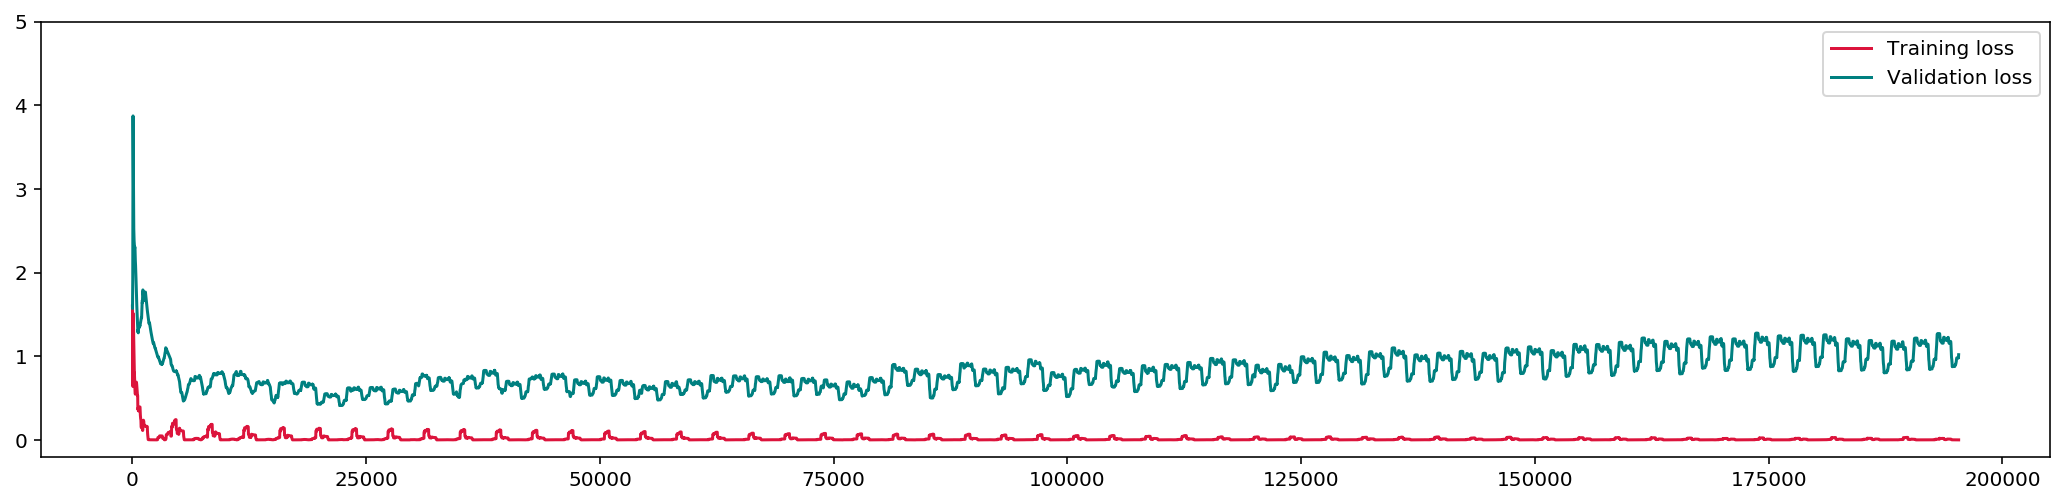

In [63]:

smoothed_loss = hm.running_mean(losses['train'], 500)
smoothed_loss_train = hm.running_mean(losses['validation'], 4050)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
plt.ylim([-0.2,5])
plt.show()

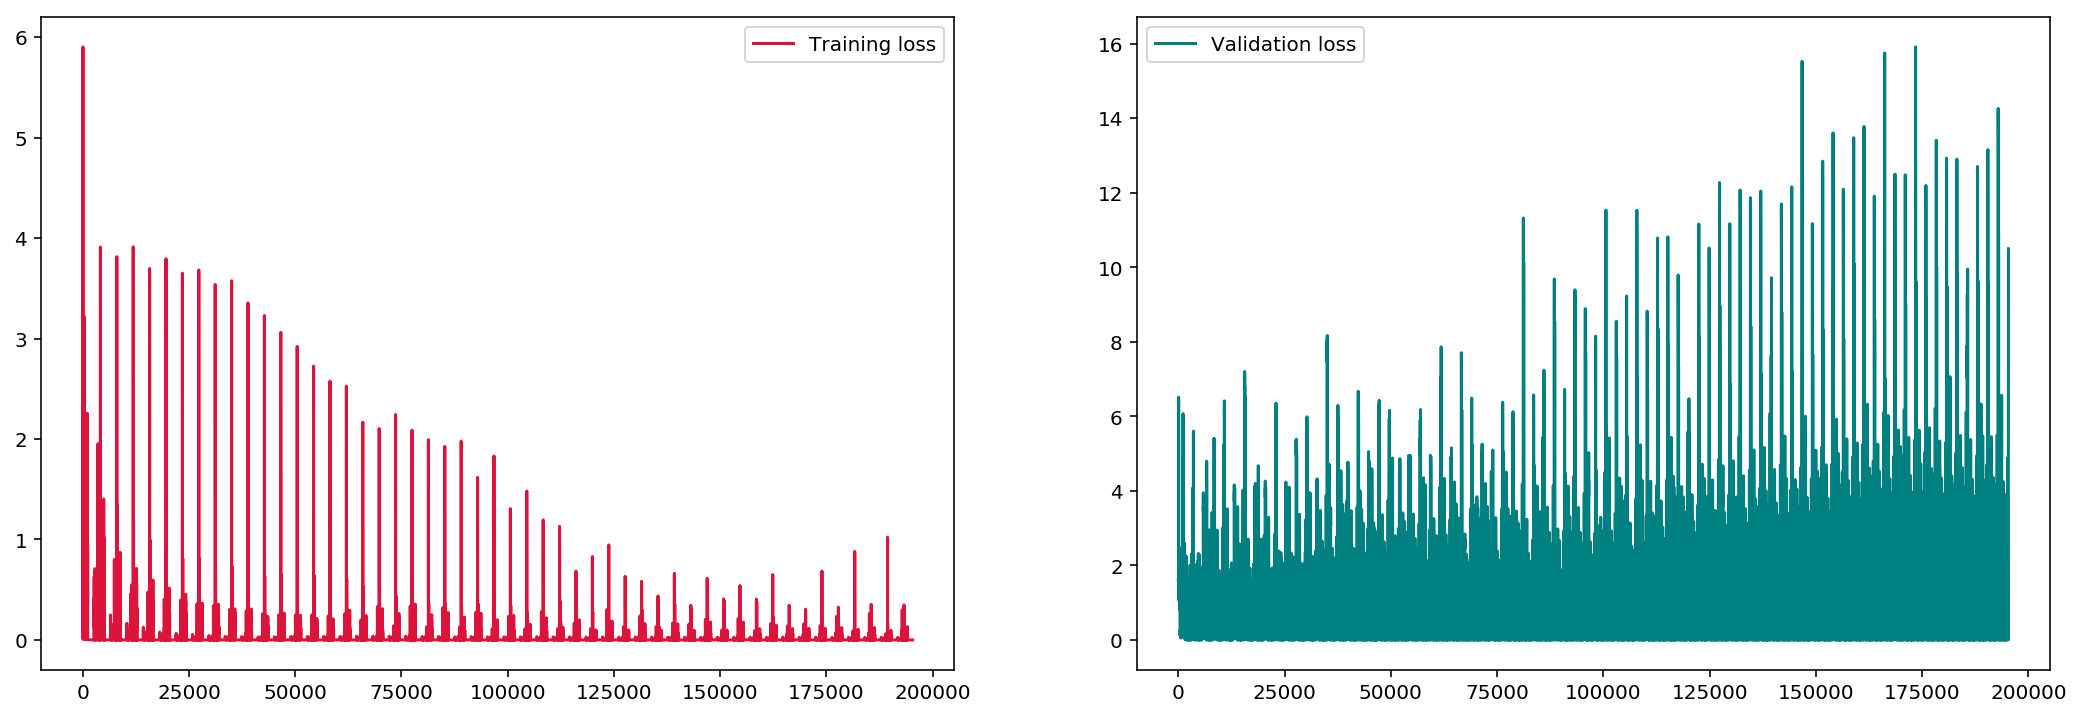

In [57]:
smoothed_loss = hm.running_mean(losses['train'], 10)
smoothed_loss_train = hm.running_mean(losses['validation'], 25)

fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax2.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()

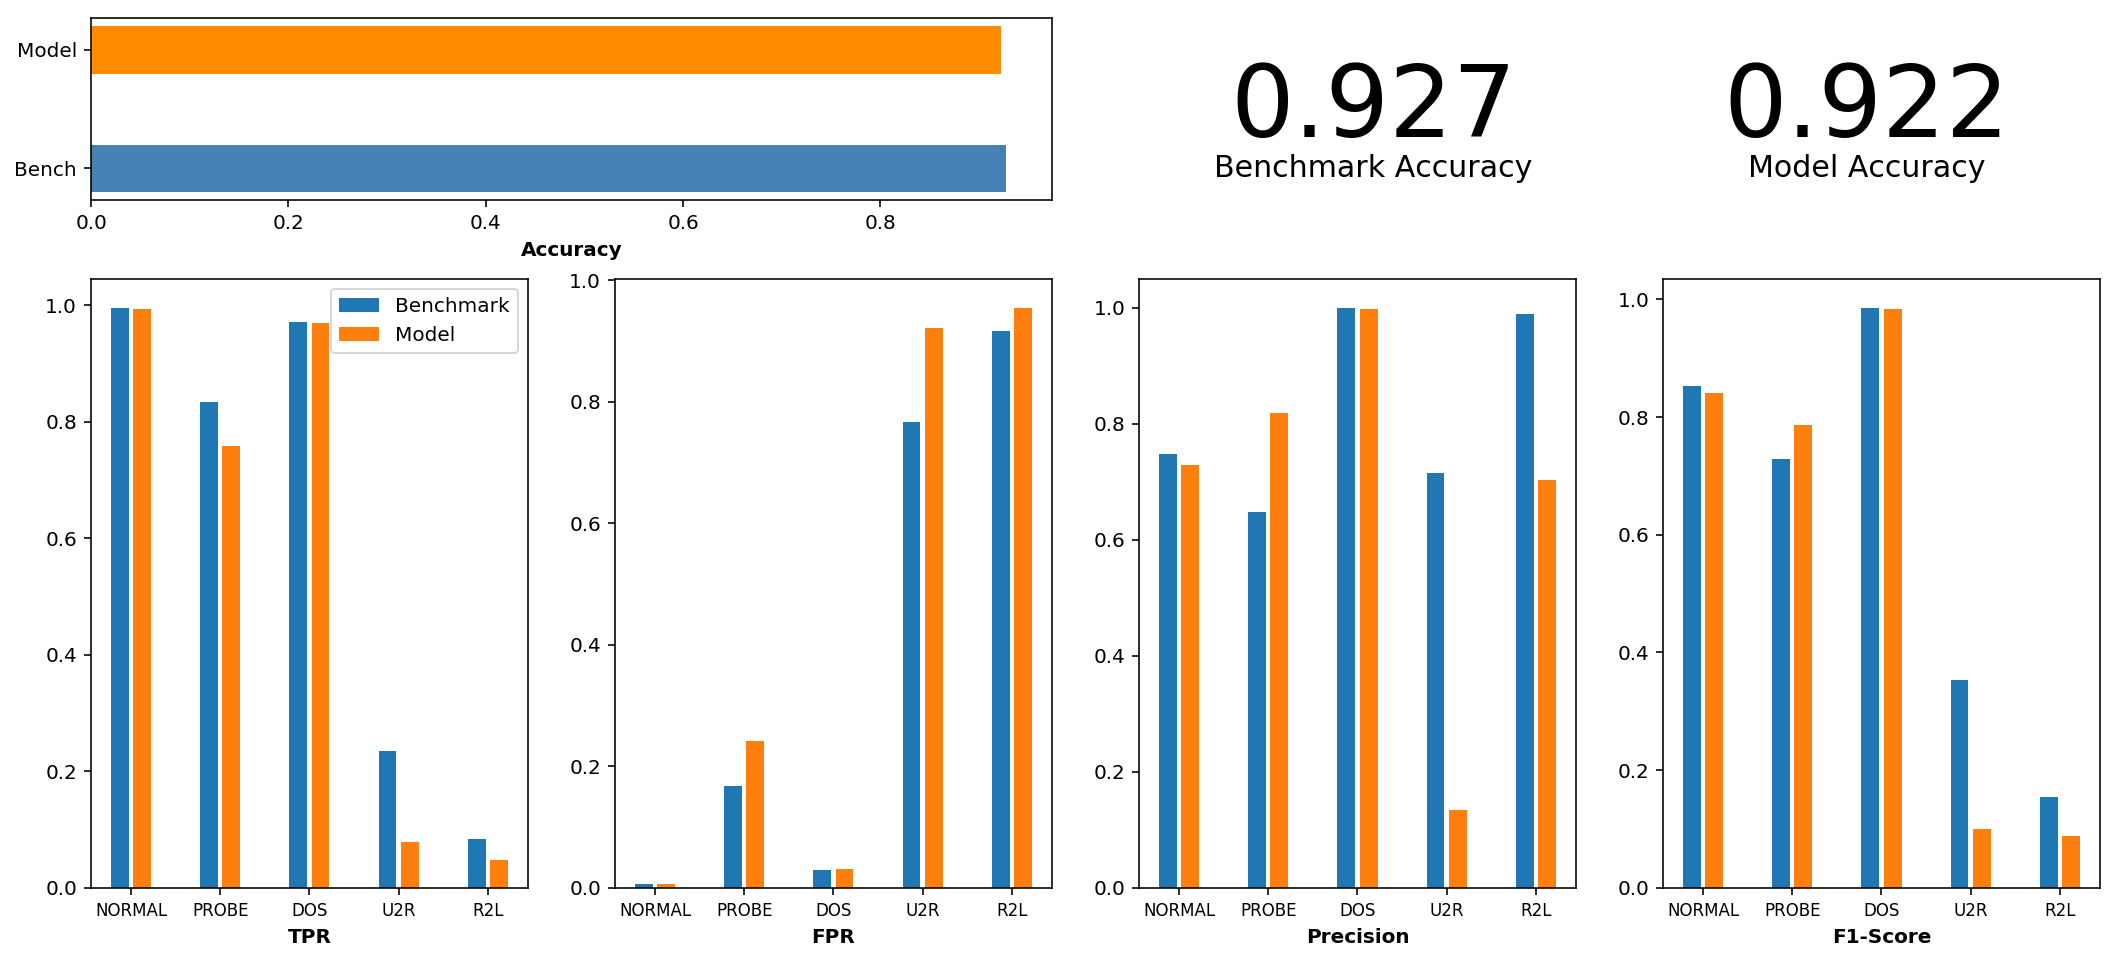

In [58]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)

